<a href="https://colab.research.google.com/github/Zhmuda/methane_project/blob/main/start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка данных

In [ ]:
import torch
import torch.nn as nn
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, Dataset, random_split
%matplotlib inline

import glob
from platform import python_version
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

In [ ]:
data_set = arff.loadarff('/content/methane_data.arff')
data_frame = pd.DataFrame(data_set[0])
data_frame = data_frame.iloc[:80000,:]
data_frame.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/methane_data.arff'

In [ ]:
data_frame['Date_Time'] = pd.to_datetime(data_frame[['year', 'month', 'day', 'hour', 'minute']])
data_frame['MM262_Filtered'] = data_frame['MM262'].ewm(alpha=0.01).mean()
target_data = data_frame['MM262_Filtered']
target_data = target_data[60:]
target_data = target_data.reset_index()
data_frame = data_frame[:-60]
data_frame = data_frame.reset_index()
data_frame['Target'] = target_data['MM262_Filtered']
data_frame.drop(['year', 'month', 'day', 'hour', 'minute', 'second','MM263','MM264','MM256','F_SIDE'], axis=1, inplace=True)

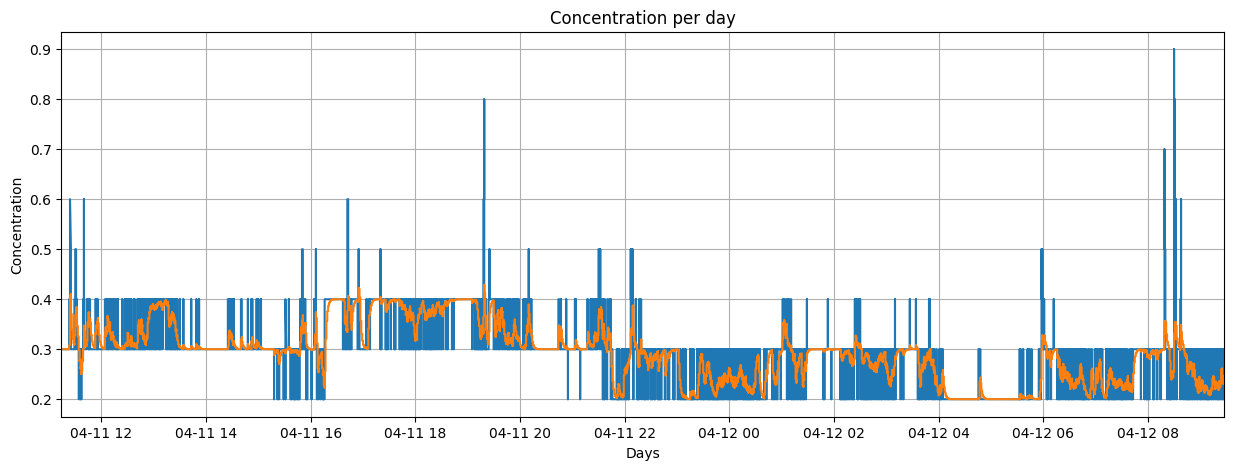

In [ ]:
## Настройка графика
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Concentration per day')
plt.ylabel('Concentration')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data_frame['Date_Time'], data_frame['MM262'])
plt.plot(data_frame['Date_Time'], data_frame['MM262_Filtered'])

In [ ]:
data_frame.drop(['Date_Time','MM262',], axis=1, inplace=True)
data_frame.shape
data_frame.head()

In [ ]:
df_train = data_frame[:56000]
df_val = data_frame[56001:64000]
df_test = data_frame[64001:80000]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [ ]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [ ]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

# Классы

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
import time
import random


class Optimization:


    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [ ]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

# Раздел

In [ ]:
model_1 = Model(input_size=25, hidden_size=21, output_size=1)
model_1
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [ ]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.16. Validation loss: 0.11. Avg future: 0.00. Elapsed time: 91.48s.
Epoch 2 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 89.28s.
Epoch 3 Train loss: 0.00. Validation loss: 0.02. Avg future: 0.00. Elapsed time: 92.60s.
Epoch 4 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 89.90s.
Epoch 5 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 91.50s.
Epoch 6 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 89.90s.
Epoch 7 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 92.49s.
Epoch 8 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 115.67s.
Epoch 9 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 100.62s.
Epoch 10 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 93.03s.
Epoch 11 Train loss: 0.00. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 89.97s.
Epoch 12 Train lo

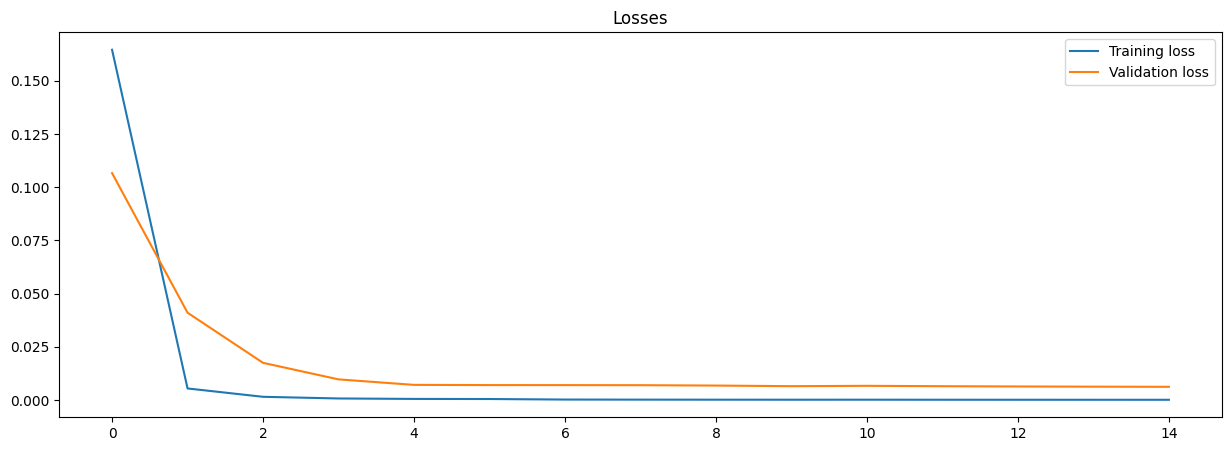

In [ ]:
optimization_1.plot_losses()

In [ ]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1)
df_result_1 = scaler.inverse_transform(df_result_1)
df_result_1

print("Test loss %.4f" % test_loss_1)

Test loss 14.8247


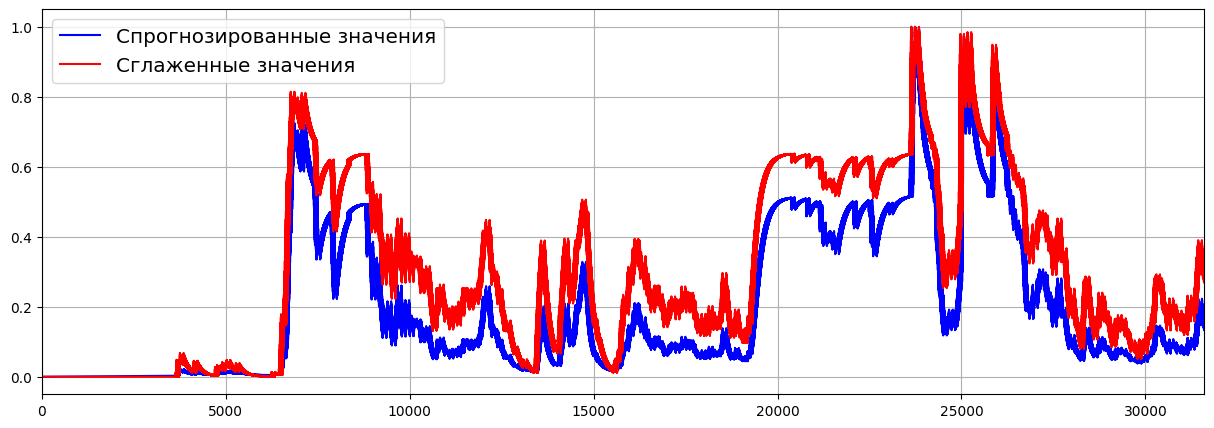

In [ ]:
## Настройка графика
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size



min_value = min(predicted_1)
max_value = max(predicted_1)

normalized_array_pr = [(x - min_value) / (max_value - min_value) for x in predicted_1]

min_value = min(actual_1)
max_value = max(actual_1)

normalized_array_ac = [(x - min_value) / (max_value - min_value) for x in actual_1]

plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(normalized_array_pr, color="b", label='Спрогнозированные значения')
plt.plot(normalized_array_ac, color="r", label='Сглаженные значения')
plt.legend(loc='best', fontsize='x-large')